In [1]:
from Classes.embedding import *
from Evaluation.code_evaluation import * 
from Evaluation.sentiment_analysis import *
from Utils.methods import *

import sys
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_style("whitegrid")

Using TensorFlow backend.


*Prior to running the experiments, embeddings have to be downloaded. In case this is already done, skip this step.*

In [14]:
!{sys.executable} -m pip -q install gdown
!gdown https://drive.google.com/uc?id=1DiICKbyfP6-JrRk7c9LU4ENgrsjucpFg
!unzip datasets.zip -d Datasets/ && rm datasets.zip

In [3]:
emb_names = ['word2vec', 'glove', 'fasttext']
emb_name = emb_names[0]
embedding = Word_Embedding(f'Datasets/embeddings/{emb_name}.txt')

Regular embedding successfully read. Shape: (76078, 300)


In [4]:
attribute_sets, attribute_sets_pairs, targets_sets = get_sets(embedding.words, target_set_reduction=True)
sets = union_of_dictionaries(attribute_sets, targets_sets)
subspace_words = get_def_seeds(sets)
bias_combinations = get_combinations(sets, attribute_sets_pairs)
bias_weat, bias_levels_d, d_values, p_values, m_before = weat_analysis(embedding, bias_combinations, sets, steps = 1000)
target_at_dict = get_SW_dict(bias_weat, 0.7)

# HardWEAT

<img src="Images/hard_weat.gif" width="900" align="center">

In [5]:
hard_debiased = copy.deepcopy(embedding)
hard_debiased.hard_weat(bias_levels_d, bias_combinations, subspace_words, sets, neighbors_threshold=0.5)
hard_debias_weat, hard_debias_levels_d, _, _, _ = weat_analysis(hard_debiased, bias_combinations, sets, steps = 1000)

Start of neutralization, there is total of 75630 neutral words out of total 76078 words.
Neutralization done in 1.479s, starting with neighbor thresholding and equidistancing...
Finished with all gender subcategories
Finished with all race subcategories
Finished with all religion subcategories
Equidistancing done in 14.836s.


# SoftWEAT

<img src="Images/soft_weat.gif" width="750" align="center">

In [6]:
soft_debiased = copy.deepcopy(embedding)
lambda_parameter = 0.5
soft_debiased.soft_weat(sets, target_at_dict, bias_combinations, l=lambda_parameter, nullspace_iterations=3)
soft_debias_weat, soft_debias_levels_d, _, _, m_after  = weat_analysis(soft_debiased, bias_combinations, sets, steps = 1000)

Subclass male_terms finished.
Subclass female_terms finished.
Subclass black_names finished.
Subclass white_names finished.
Subclass islam_words finished.
Subclass atheism_words finished.
Subclass christianity_words finished.


In [7]:
print(f'Bias levels before debiasing: {bias_levels_d}.')
print(f'Bias levels after SoftWEAT: {soft_debias_levels_d}.')
print(f'Bias levels after HardWEAT: {hard_debias_levels_d}.')

Bias levels before debiasing: {'gender': 0.72, 'race': 0.53, 'religion': 0.48}.
Bias levels after SoftWEAT: {'gender': 0.45, 'race': 0.25, 'religion': 0.22}.
Bias levels after HardWEAT: {'gender': 0.0, 'race': 0.0, 'religion': 0.0}.


## Mikolov and Rank Task Evaluation

In [8]:
embeddings_dict = {'original': embedding, 'hardweat': hard_debiased, 'softweat': soft_debiased}
rank_results, mikolov_results = {}, {}

for emb_type, emb_obj in embeddings_dict.items():
    rank_results[emb_type] = rank_evaluation(emb_obj)
    mikolov_results[emb_type] = mikolov_evaluation(emb_to_gensim(emb_obj))
    print(f'Done {emb_type}.')

Done original.
Done hardweat.
Done softweat.


In [9]:
rank_results_for_pd = []
for rank_dataset in list(rank_results['original'].keys()) :
    rank_results_for_pd.append([rank_dataset, rank_results['original'][rank_dataset], rank_results['softweat'][rank_dataset], rank_results['hardweat'][rank_dataset]])
    
mikolov_res_for_pd = []
for mikolov_part in list(mikolov_results['original'].keys()) :
    mikolov_res_for_pd.append([mikolov_part, mikolov_results['original'][mikolov_part], mikolov_results['softweat'][mikolov_part], mikolov_results['hardweat'][mikolov_part]])

In [10]:
pd.DataFrame(rank_results_for_pd, columns = ['Key','Original', 'SoftWEAT', 'HardWEAT'])

,Key,Original,SoftWEAT,HardWEAT
0,WS,69.33,69.58,65.21
1,RG65,74.94,75.13,66.02
2,RW,55.78,55.76,55.71
3,MEN,77.07,76.92,75.51
4,MTurk,67.14,66.53,66.13
5,SimLex,44.27,44.31,44.09
6,SimVerb,36.54,36.50,36.51


In [11]:
pd.DataFrame(mikolov_res_for_pd, columns = ['Key','Original', 'SoftWEAT', 'HardWEAT'])

,Key,Original,SoftWEAT,HardWEAT
0,capital-common-countries,0.27,0.27,0.25
1,capital-world,0.18,0.15,0.16
2,currency,0.21,0.21,0.21
3,city-in-state,0.15,0.15,0.15
4,family,0.85,0.85,0.32
5,gram1-adjective-to-adverb,0.31,0.31,0.31
6,gram2-opposite,0.45,0.45,0.44
7,gram3-comparative,0.92,0.92,0.92
8,gram4-superlative,0.91,0.91,0.91
9,gram5-present-participle,0.79,0.79,0.79


## Sentiment Analysis Task Evaluation

In [12]:
dictionary_categories, parameters_dict, target_sets_dict = get_sent_analysis_sets()
target_pairs = ['islam_christianity', 'male_female', 'black_white']
target_pair = target_pairs[0]
datasets_and_dicts = get_dataset_and_dicts( target_sets_dict[target_pair][emb_name], parameters_dict)
results = compare_embeddings(datasets_and_dicts, embeddings_dict, parameters_dict)

Training shape: (821, 50)
Test shape: (290, 50)
Shape of modified test input: (100, 50)
Shape of modified test input: (100, 50)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
F1 score for original embedding, 1.model: 0.77
F1 score for original embedding, 2.model: 0.72
F1 score for original embedding, 3.model: 0.73
F1 score for original embedding, 4.model: 0.73
F1 score for original embedding, 5.model: 0.71
F1 score for original embedding, 6.model: 0.71
________________________________________________________________
F1 score for hardweat embedding, 1.model: 0.74
F1 score for hardweat embedding, 2.model: 0.74
F1 score for hardweat embedding, 3.model: 0.72
F1 score for hardweat embedding, 4.model: 0.74
F1 score for hardweat embedding, 5.model: 0.7
F1 score for hardweat embedding, 6.model: 0.75
________________________________________________________________
F1 score for softweat embedding, 1.model: 0.71
F1 score for

/Users/Radomir/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


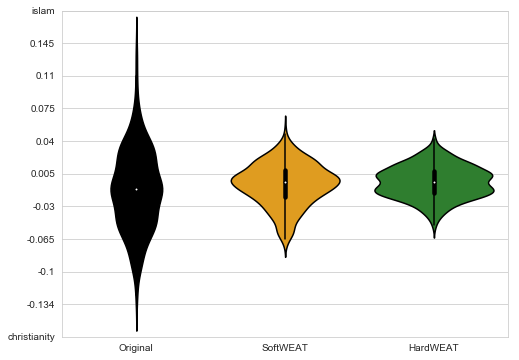

In [13]:
original_pol = [r for res in results['original'] for r in res[0]]
softweat_pol = [r for res in results['softweat'] for r in res[0]]
hardweat_pol = [r for res in results['hardweat'] for r in res[0]]
constant = 0.025
all_values = np.array([original_pol, softweat_pol, hardweat_pol]).flatten()
min_value, max_value = min(all_values)-constant, max(all_values)+constant

plt.figure(figsize=(8, 6))
set_names = target_pair.split('_')
ax = sns.violinplot(data=[original_pol, softweat_pol, hardweat_pol], palette=['black', '#ffa500', 'forestgreen'])
ax_range = np.linspace(min_value, max_value, 11)
ax.set_xticklabels(['Original', 'SoftWEAT', 'HardWEAT'])
ax.set_ylim([min(ax_range), max(ax_range)])
ax.set_yticks(ax_range)
_ = ax.set_yticklabels([set_names[1]] + list(np.round(np.linspace(min_value, max_value, 9), 3)) + [set_names[0]])